# Walmart Recruiting: Trip Type Classification

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
sns.set() 

## Exploratory Analysis

In [2]:
# Read data
data_raw = pd.read_csv(r"C:\Users\data\Walmart\train.csv", encoding='utf-8', engine='python')
data_raw.head(20)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0
5,26,8,Friday,2.006619e+09,2,PAINT AND ACCESSORIES,1017.0
6,26,8,Friday,2.006614e+09,1,PAINT AND ACCESSORIES,1017.0
7,26,8,Friday,7.004803e+09,1,PAINT AND ACCESSORIES,2802.0
8,26,8,Friday,2.238495e+09,1,PAINT AND ACCESSORIES,4501.0
9,26,8,Friday,2.238400e+09,-1,PAINT AND ACCESSORIES,3565.0


In [3]:
# Data preprocessing
# Check duplicate values
data_raw.duplicated().sum()

5704

In [4]:
# Check missing values
data_raw.isnull().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

In [5]:
def preprocessing(data):
    # Delete duplicate values
    data = data.drop_duplicates()
    # Process missing values
    data = data.fillna({'Upc':0,'FinelineNumber':0,'DepartmentDescription':"MISSING"})
    # Create dummy variables for the categorical variable
    data = pd.get_dummies(data,columns=['Weekday','DepartmentDescription'])
    return data

In [6]:
# Data after preprocess
data = preprocessing(data_raw)
data

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,999,5,6.811315e+10,-1,1000.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,7,6.053882e+10,1,8931.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,30,7,7.410811e+09,1,4504.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26,8,2.238404e+09,2,3565.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26,8,2.006614e+09,2,1017.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647049,39,191346,3.239000e+10,1,1118.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
647050,39,191346,7.874205e+09,1,1752.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
647051,39,191346,4.072000e+03,1,4170.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
647052,8,191347,4.190008e+09,1,1512.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Data aggregation
def aggregation(data):
    # Get the absolute value of the ScanCount
    data.ScanCount = data.ScanCount.abs().values
    # Aggregate Upc, ScanCount, FinelineNumber
    Data = pd.DataFrame({'Upc': data.groupby('VisitNumber').Upc.mean().values,
                         'ScanCount': data.groupby('VisitNumber').ScanCount.sum().values,
                         'FinelineNumber': data.groupby('VisitNumber').FinelineNumber.mean().values})
    # Aggregate WeekDay, DepartmentDescription
    for i in range(4, 11):
        Data[data.columns[i]] = data.groupby(
        'VisitNumber')[data.columns[i]].mean().values
    for i in range(11, 80):
        Data[data.columns[i]] = data.groupby(
        'VisitNumber')[data.columns[i]].sum().values
    return Data

In [8]:
# Data after aggregation
Data = aggregation(data.drop('TripType',axis=1))
Data.insert(0,'TripType',data.groupby('VisitNumber').TripType.mean().values)
Data

,TripType,Upc,ScanCount,FinelineNumber,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,999,6.811315e+10,1,1000.000000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,3.397481e+10,2,6717.500000,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,26,1.851843e+10,32,2550.826087,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,3.566959e+08,3,1906.333333,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,5.669755e+09,3,3357.666667,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95669,25,6.451750e+10,9,4855.857143,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,22,3.229144e+10,5,3025.400000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
95671,39,9.167536e+09,17,3838.615385,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,39,5.806352e+09,17,4288.705882,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95674 entries, 0 to 95673
Data columns (total 80 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   TripType                                           95674 non-null  int64  
 1   Upc                                                95674 non-null  float64
 2   ScanCount                                          95674 non-null  int64  
 3   FinelineNumber                                     95674 non-null  float64
 4   Weekday_Friday                                     95674 non-null  uint8  
 5   Weekday_Monday                                     95674 non-null  uint8  
 6   Weekday_Saturday                                   95674 non-null  uint8  
 7   Weekday_Sunday                                     95674 non-null  uint8  
 8   Weekday_Thursday                                   95674 non-null  uint8  
 9   Weekda

#### 95684 observations, 79 features and 72 numerics, 7 categories. Two float types and 77 int types. One target variable.

In [10]:
Data.TripType.value_counts().count() 

38

### 38 distinct types. ScanCout means the total number of items purchased. Upc (universal product code). FinelineNumber: Walmart assigns a four-digit number to each fineline to make sure that each product be placed accurately within a fineline.

<AxesSubplot:xlabel='FinelineNumber', ylabel='Count'>

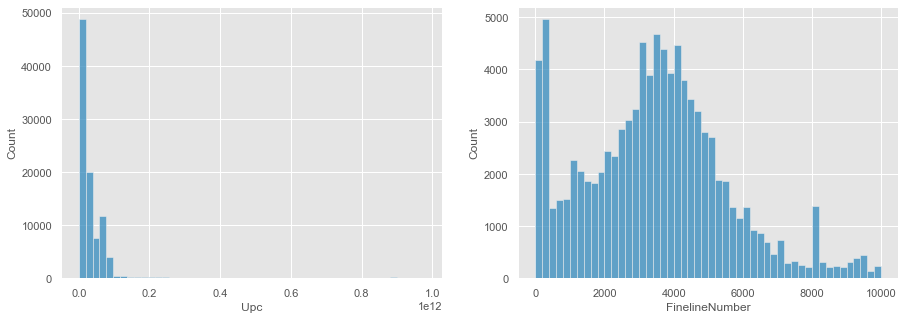

In [11]:
# Plot distribution of Upc and FinelineNumber
plt.style.use('ggplot')
fig,axes = plt.subplots(1,2)
fig.set_size_inches(15,5)
sns.histplot(Data.Upc,ax=axes[0],bins=50)
sns.histplot(Data.FinelineNumber,ax=axes[1],bins=50)

<AxesSubplot:xlabel='ScanCount', ylabel='Count'>

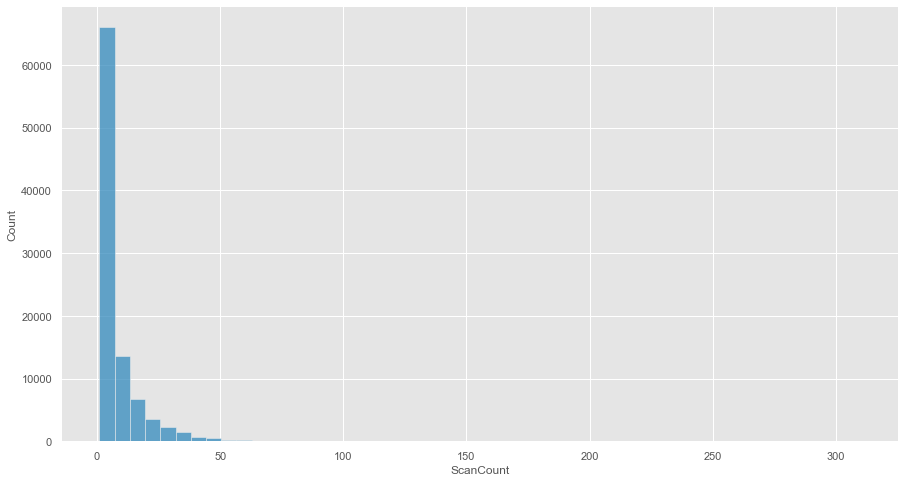

In [12]:
# Plot distribution of ScanCount
plt.figure(figsize=(15,8))
sns.histplot(Data.ScanCount,bins=50)

<AxesSubplot:xlabel='count', ylabel='TripType'>

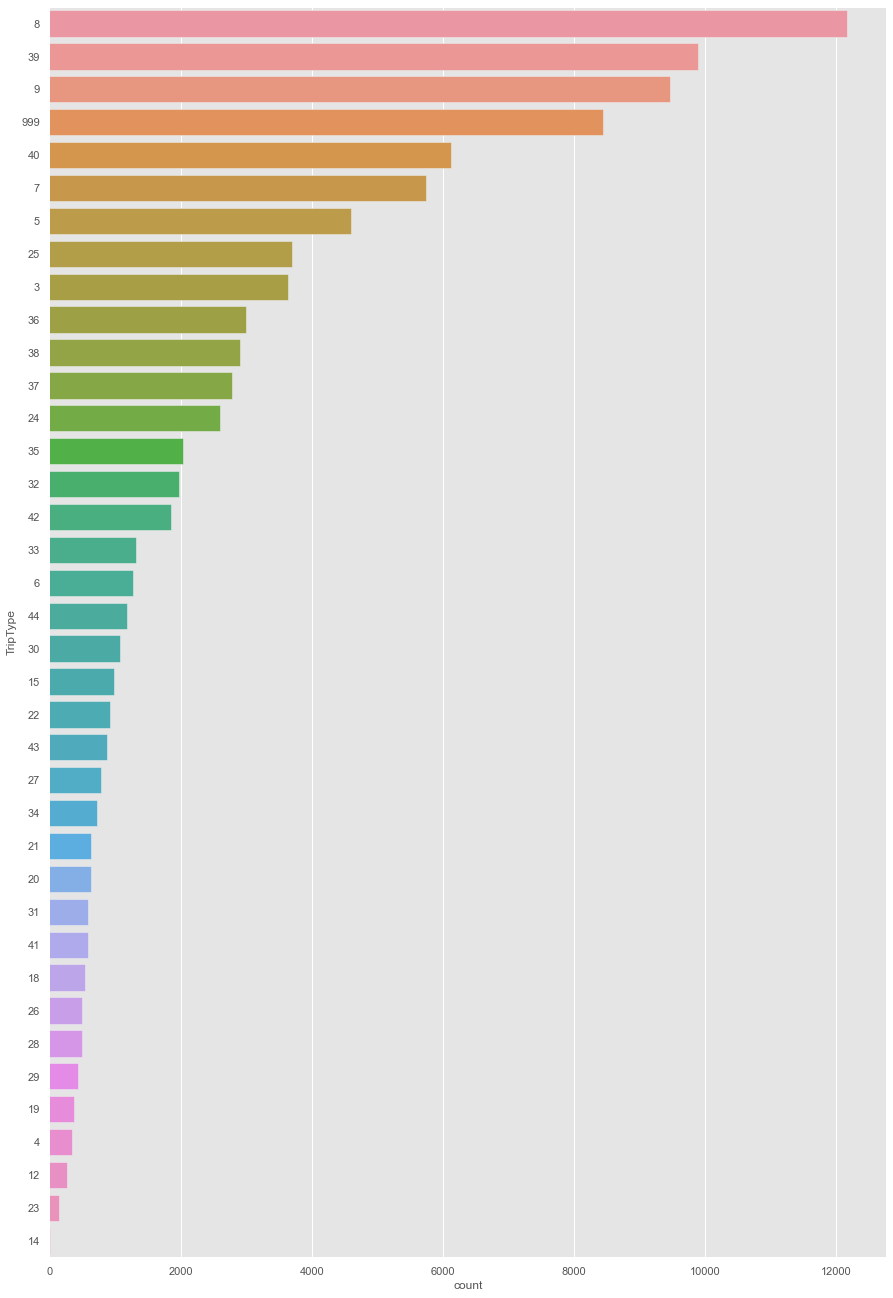

In [13]:
# Distribution of TripType
plt.figure(figsize=(15,23))
sns.countplot(y=Data.TripType,order=Data.TripType.value_counts().index)

<AxesSubplot:xlabel='TripType', ylabel='FinelineNumber'>

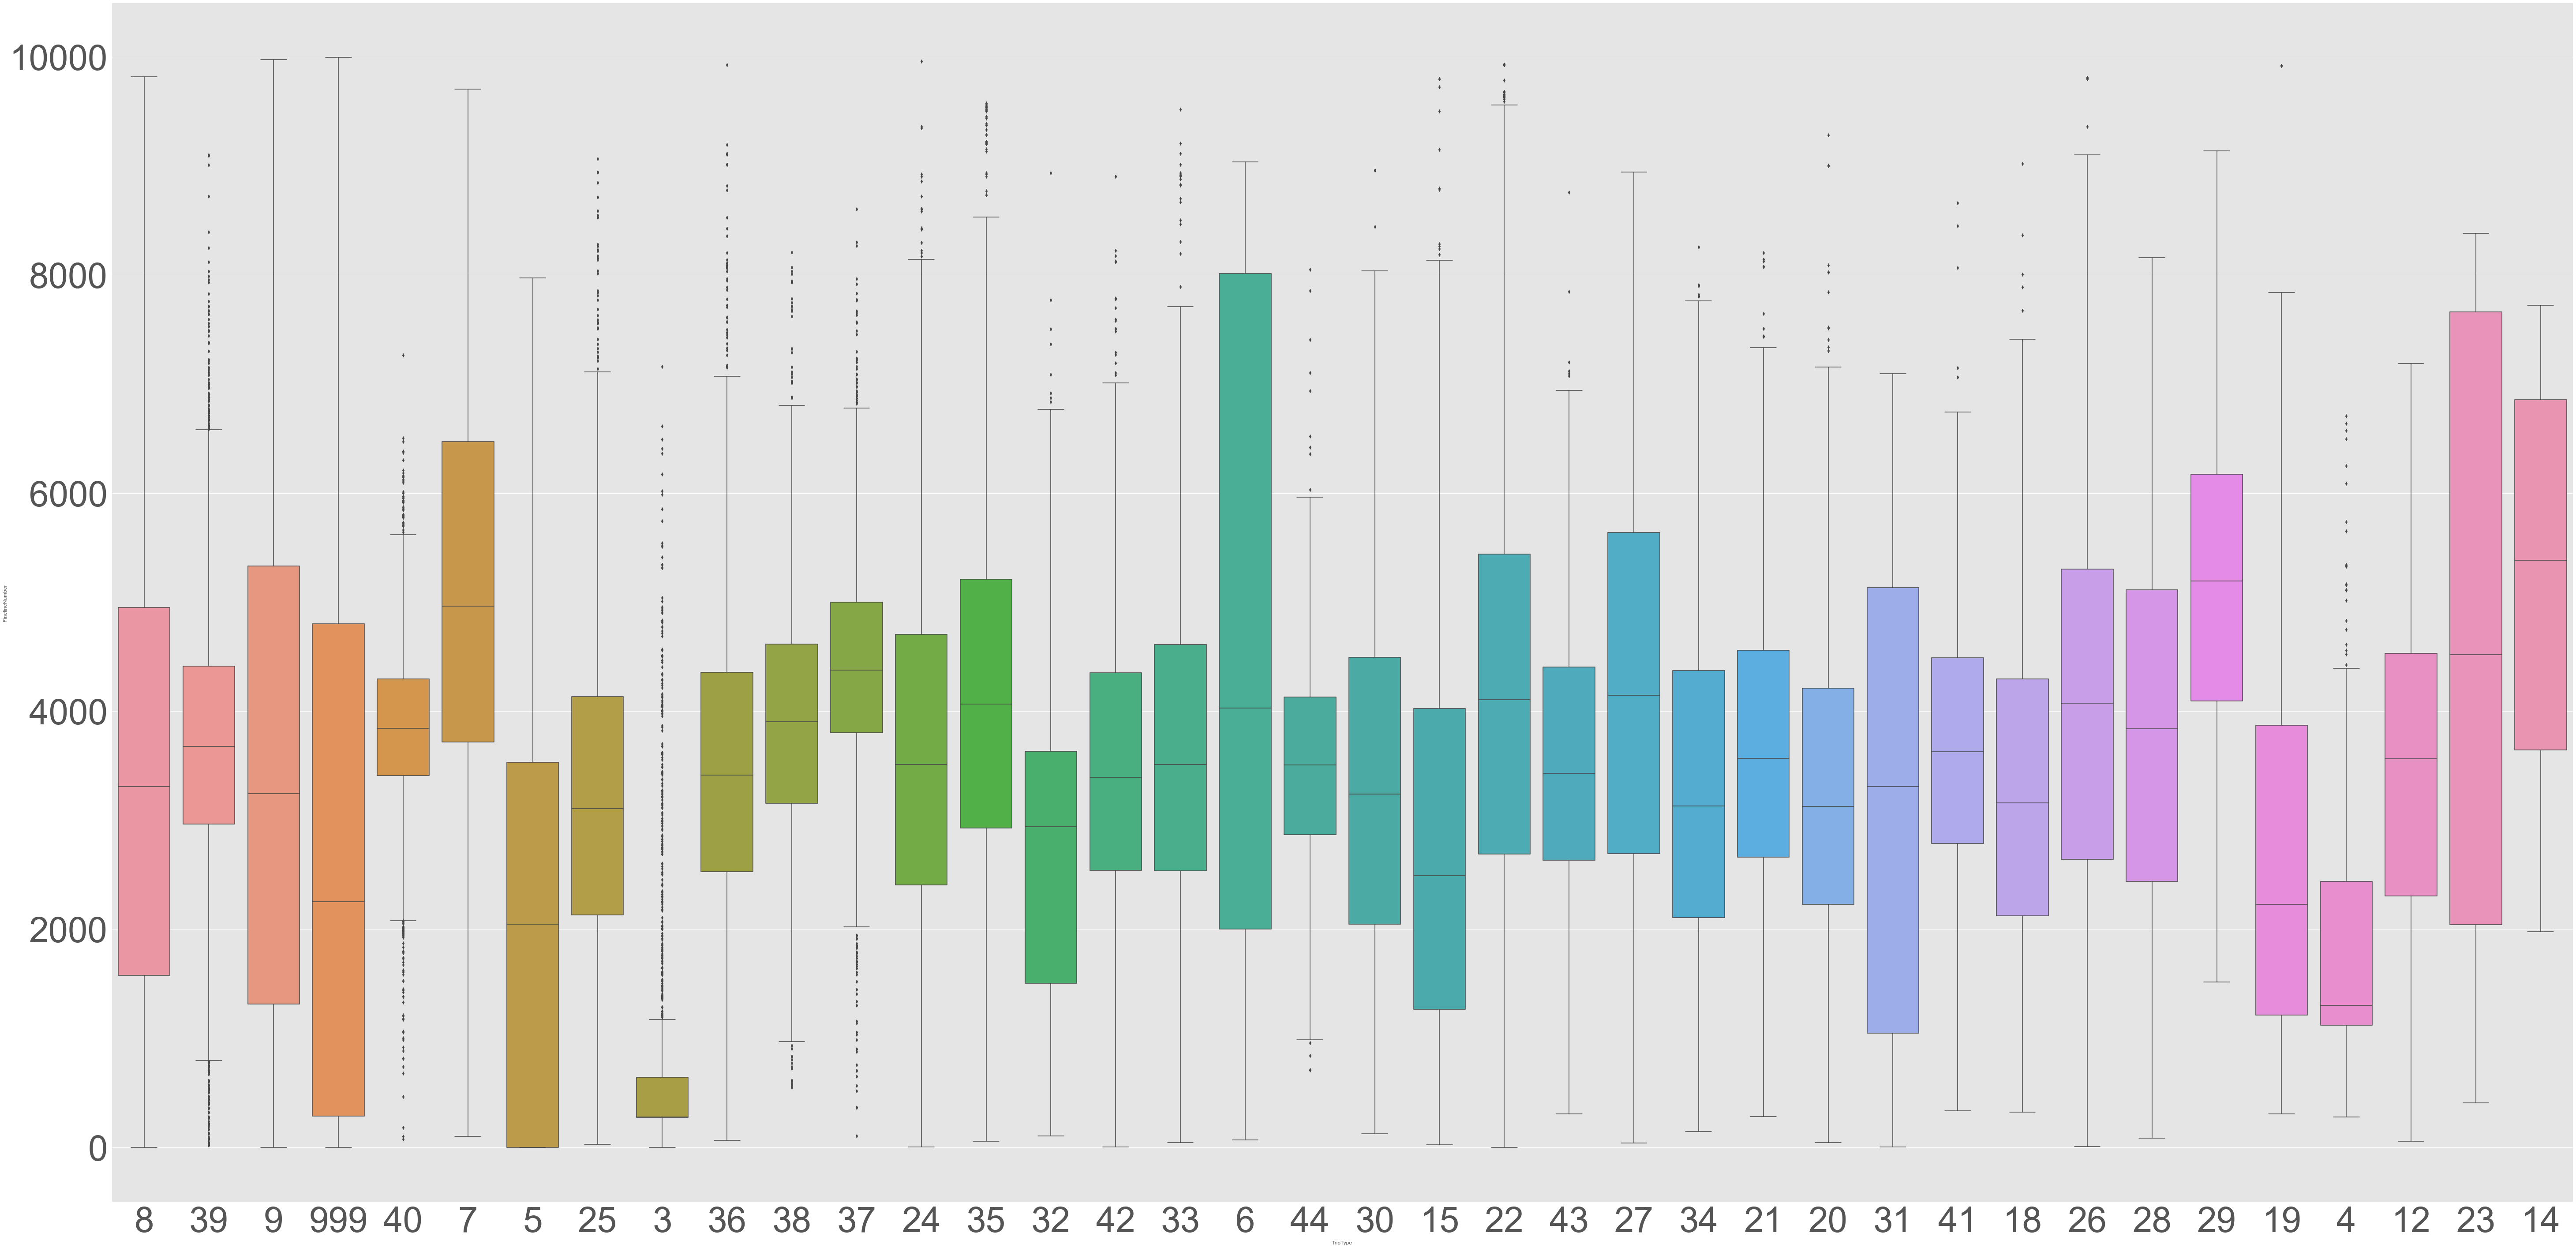

In [14]:
# Segmentation for FinelineNumber
plt.figure(figsize=(100,50))
plt.xticks(fontsize=80)
plt.yticks(fontsize=80)
sns.boxplot(x='TripType',y='FinelineNumber',order=Data.TripType.value_counts().index,data=Data)

<AxesSubplot:xlabel='TripType', ylabel='Upc'>

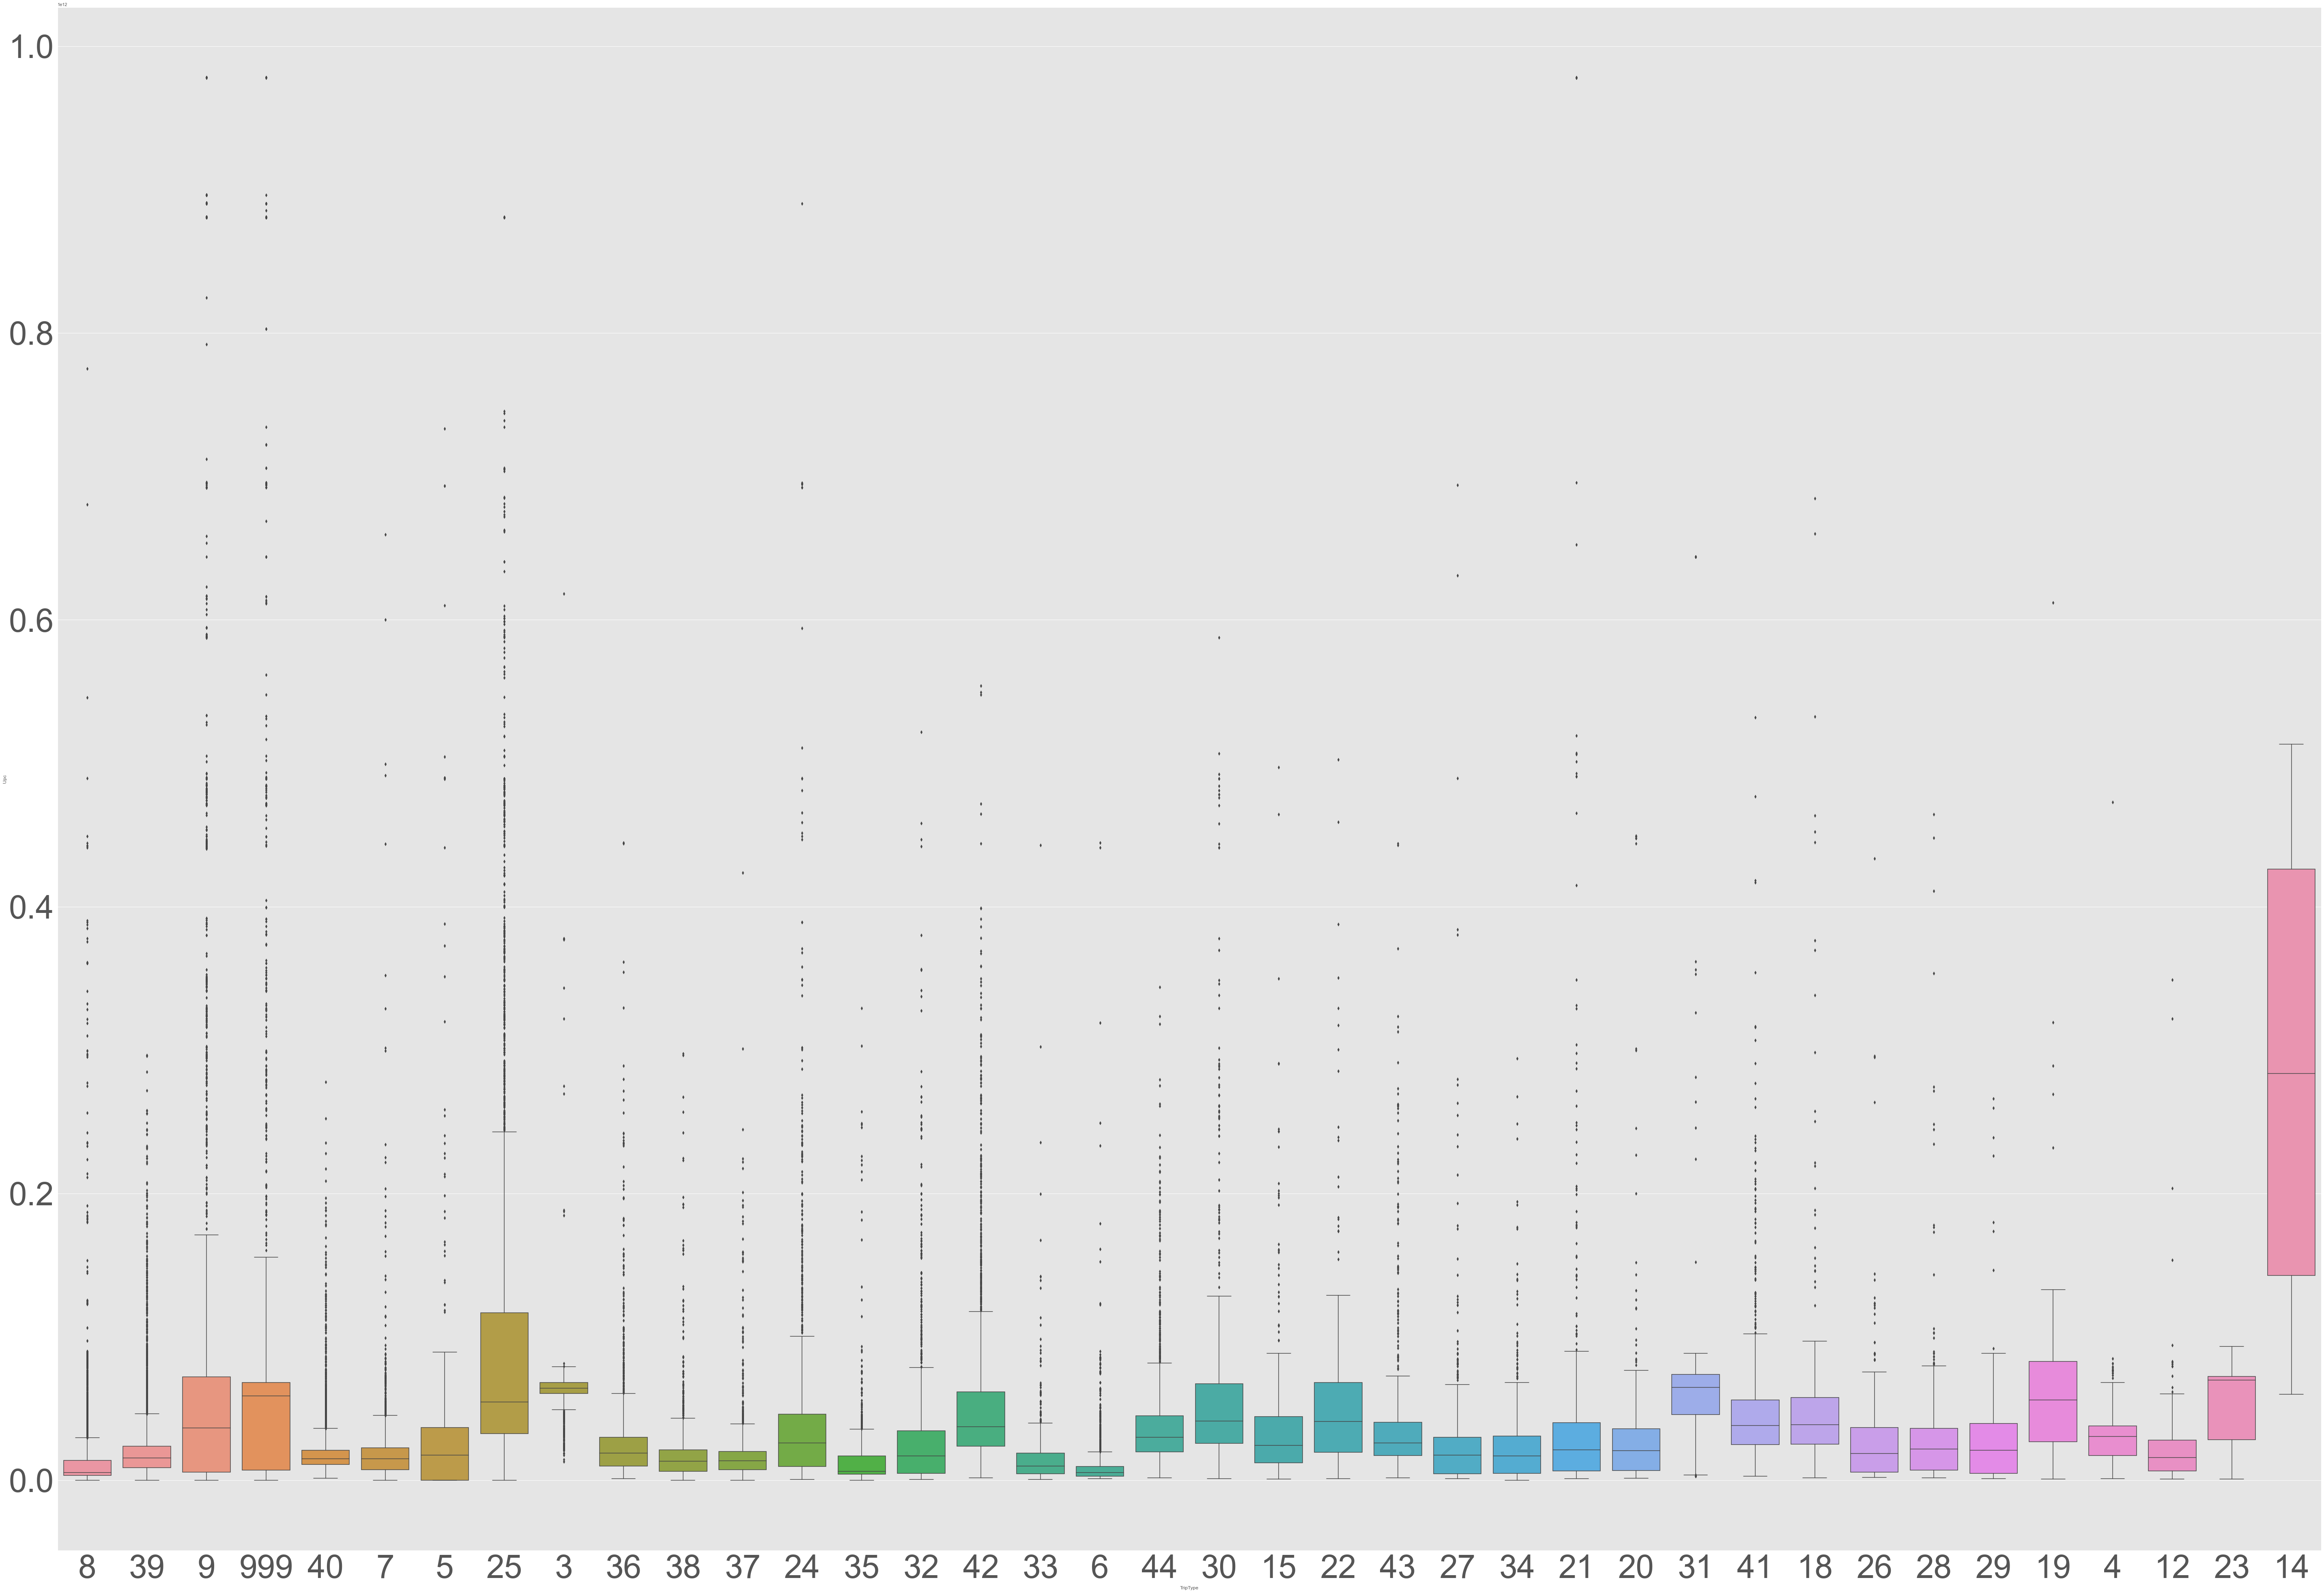

In [15]:
# Segmentation for Upc
plt.figure(figsize=(100,70))
plt.xticks(fontsize=80)
plt.yticks(fontsize=80) 
sns.boxplot(x='TripType',y='Upc',order=Data.TripType.value_counts().index,data=Data)

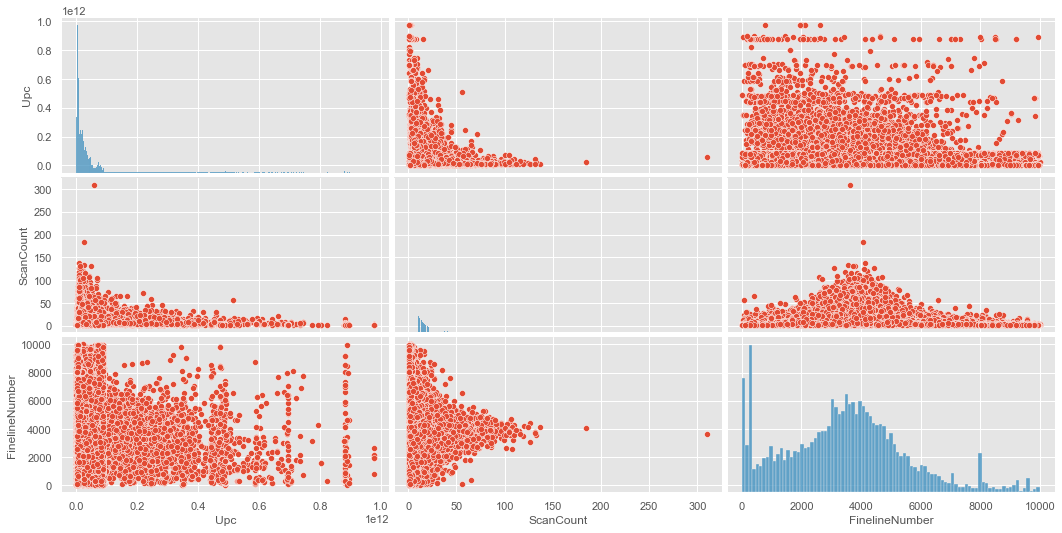

In [16]:
# Correlations between Upc, ScanCount and FinelineNumber
data_corr = Data[['Upc','ScanCount','FinelineNumber']] 
# Pair plot
sns.pairplot(data_corr,aspect=2) 

<AxesSubplot:>

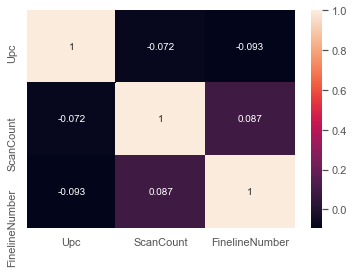

In [17]:
# Heatmap
sns.heatmap(data_corr.corr(),annot=True)

## Feature Engineering

In [18]:
def feature_engineering(data_raw,data,Data):
    # Create return feature to indicate if there is a return in a shooping
    def return_map(x):
        Return = 1 if x < 0 else 0
        return Return
    data['return'] = data.ScanCount.map(return_map)
    Data['Return'] = data.groupby('VisitNumber')['return'].sum().values
    def r(x):
        Return = 1 if x>=1 else 0
        return Return
    Data['Return'] = Data['Return'].map(r)
    # The number of return items
    def return_num(x):
        y = abs(x) if x<0 else 0
        return y
    data['Number_of_Return'] = data.ScanCount.map(return_num) 
    Data['Number_of_Return'] = data.groupby('VisitNumber')['Number_of_Return'].sum().values
    # Number_of_Departments shows how many departments did the customer buy from
    d = data_raw.drop_duplicates() 
    d = d.fillna({'Upc':0,'FinelineNumber':0,'DepartmentDescription':"MISSING"})
    unique_departemnts = d.groupby('VisitNumber')['DepartmentDescription'].unique()
    for i in range(0,unique_departemnts.size):
        unique_departemnts.iloc[i] = unique_departemnts.iloc[i].size
    Data['Number_of_Departments'] = unique_departemnts.values
    # Combine sparse classes  
    Others = 0
    Del = []
    for i in range(0,Data.shape[1]):
        if (Data[Data.columns[i]]!=0).sum()<=50:
            Others += Data[Data.columns[i]]
            Del.append(Data.columns[i])
    Data = Data.drop(Del,axis=1)
    Data.insert(Data.columns.get_loc('Return'),'DepartmentDescription_OTHERS',Others.values)
    # Average of Upc and FinelineNumber
    d['FinelineNumber_2'] = abs(d.FinelineNumber * d.ScanCount)
    d['Upc_2'] = abs(d.Upc * d.ScanCount)
    Data['Avg_FinelineNumber'] = d.groupby('VisitNumber')['FinelineNumber_2'].sum().values / Data.ScanCount
    Data['Avg_Upc'] = d.groupby('VisitNumber')['Upc_2'].sum().values / Data.ScanCount
    # Number_of_Fineline means how many finelines did a customer buy from at a time.
    m = d.groupby('VisitNumber')['FinelineNumber'].value_counts()
    n = d.VisitNumber.unique()
    L = []
    for i in range(0,Data.shape[0]):
        L.append(m[n[i]].count())
    Data['Number_of_Fineline'] = L
    return Data

In [19]:
# Data after feature engineering
data = feature_engineering(data_raw,data,Data)
data

,TripType,Upc,ScanCount,FinelineNumber,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,...,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_OTHERS,Return,Number_of_Return,Number_of_Departments,Avg_FinelineNumber,Avg_Upc,Number_of_Fineline
0,999,6.811315e+10,1,1000.000000,1,0,0,0,0,0,...,0,0,0,0,1,1,1,1000.000000,6.811315e+10,1
1,30,3.397481e+10,2,6717.500000,1,0,0,0,0,0,...,0,0,0,0,0,0,2,6717.500000,3.397481e+10,2
2,26,1.851843e+10,32,2550.826087,1,0,0,0,0,0,...,0,0,0,0,1,2,7,2364.437500,1.961329e+10,17
3,8,3.566959e+08,3,1906.333333,1,0,0,0,0,0,...,0,0,0,0,0,0,2,1906.333333,3.566959e+08,3
4,8,5.669755e+09,3,3357.666667,1,0,0,0,0,0,...,0,0,0,0,0,0,2,3357.666667,5.669755e+09,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95669,25,6.451750e+10,9,4855.857143,0,0,0,1,0,0,...,0,0,0,0,0,0,3,5433.666667,6.056146e+10,5
95670,22,3.229144e+10,5,3025.400000,0,0,0,1,0,0,...,0,0,1,0,0,0,2,3025.400000,3.229144e+10,3
95671,39,9.167536e+09,17,3838.615385,0,0,0,1,0,0,...,0,0,0,0,0,0,8,3982.117647,9.952014e+09,12
95672,39,5.806352e+09,17,4288.705882,0,0,0,1,0,0,...,0,0,0,0,0,0,8,4288.705882,5.806352e+09,16


## Model training

In [20]:
# Divide training set and test set
x_train,x_test,y_train,y_test = train_test_split(data.iloc[:,1:],Data.TripType
                                                 ,test_size=0.2, random_state=7,stratify=Data.TripType)

In [21]:
# Build pipeline
model = make_pipeline(StandardScaler(),MLPClassifier(alpha=0.01,max_iter=300))

In [22]:
# Grid search and cross validation
param = {'mlpclassifier__alpha': [0.001, 0.01, 0.1, 1]}
grid = GridSearchCV(model, param_grid=param,cv=3)
grid.fit(x_train,y_train)

c:\users\王硕\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\王硕\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\王硕\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\王硕\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('mlpclassifier',
                                        MLPClassifier(alpha=0.01,
                                                      max_iter=300))]),
             param_grid={'mlpclassifier__alpha': [0.001, 0.01, 0.1, 1]})

In [23]:
grid.best_params_

{'mlpclassifier__alpha': 0.1}

In [25]:
grid.score(x_test,y_test)

0.707499346746799